1. Regression Models
● Train and evaluate linear regression models to predict cholesterol levels.
● Tasks:
1. Use R² and RMSE as evaluation metrics.
2. For linear regression:
■ Implement ElasticNet. Experiment with varying regularization
parameters (alpha and l1_ratio) and observe their effects on model
coefficients and performance.
3. Create a heatmap (see documentation for seaborn.heatmap) of R2 and RMSE across a range of alpha and l1_ratio. Use clear labels and a color bar to guide
interpretation.
4. Identify the top-performing configuration based on the evaluation metrics.


In [194]:
import numpy as np
import pandas as pd
import statistics as stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import root_mean_squared_error, r2_score, accuracy_score, f1_score, roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.linear_model import ElasticNet, LogisticRegression


In [195]:
def impute_missing_values(data, strategy='mean'):
    """
    Fill missing values in the dataset & perform one-hot enconding.
    :param data: pandas DataFrame
    :param strategy: str, imputation method ('mean', 'median', 'mode')
    :return: pandas DataFrame
    """

    data2=data.copy()
    # .drop("chol", axis=1) #don't manipulate feature data
    # data2=data2[data2["chol"].notna()]
    numericCols=[]
    factoredCols=[]
    colNames=list(data2.columns.values)
    # do NOT manipulate 'target' column; needed for y_train in lin_regression 

    #categorise cols by numerical or factored dtype
    for col in colNames:
        #delete cols missing 50% of data
        if pd.isnull(data2[col]).sum()>=(len(data2[col]))*.5:
            data2=data2.drop(columns=col)
        elif data2[col].dtype == 'object':
            factoredCols.append(col)
        else:
            numericCols.append(col)

        
    for col in numericCols:
        if strategy == 'mean':
            data2[col].fillna(data2[col].mean(), inplace=True)
        elif strategy=='mode':
            data2[col].fillna(data2[col].mode(), inplace=True)
        elif strategy =='median':
            data2[col].fillna(data2[col].mdeian(), inplace=True)

    
    #fill in for categorical variables?
    for col in factoredCols:
        data2[col]=data2[col].fillna(stats.mode(data2[col])) #inplace=True not working so we directly reassign

    data2 = pd.get_dummies(data2, drop_first=False)
    
    return data2

In [196]:
data0=pd.read_csv("../Data/heart_disease_uci.csv")
data=pd.DataFrame(data0.copy())

#remove rows missing target data
data = data.dropna(subset=["chol"])
# was using << copy()[data["chol"].notna()] >> but this is indexing and takes more memory

# impute missing values + one-hot encoding of feature data
X = impute_missing_values(data.drop("chol", axis=1)) # features only, dont change the target data
y = data["chol"] # target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

elastic = ElasticNet(alpha=0.01,l1_ratio=0.1)
elastic.fit(X_train, y_train)
y_pred = elastic.predict(X_test)

# Evaluation
rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Root Mean Squared Error: {rmse}")
print(f"R^2 Score: {r2}")

Root Mean Squared Error: 71.90095170395857
R^2 Score: 0.5904679236631998


C:\Users\liv_u\AppData\Local\Temp\ipykernel_8924\864980202.py:30: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data2[col].fillna(data2[col].mean(), inplace=True)
C:\Users\liv_u\AppData\Local\Temp\ipykernel_8924\864980202.py:39: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data2[col]=data2[col].fillna(stats.mo

                                            rmse  r^2 (*100)
ElasticNet(alpha=0.01, l1_ratio=0.01)  71.901559   59.046100
ElasticNet(alpha=0.1, l1_ratio=0.1)    77.248929   52.728043
ElasticNet(alpha=0.5)                  86.751406   40.382784


<Axes: >

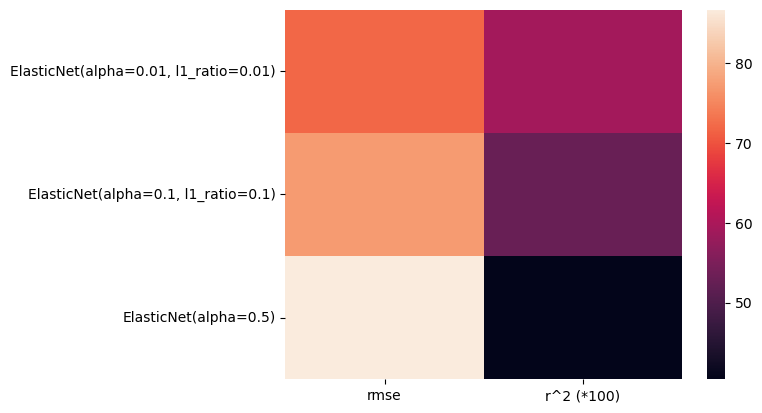

In [ ]:
elastic01 = ElasticNet(alpha=0.01,l1_ratio=0.01)
elastic01.fit(X_train, y_train)
y_pred01 = elastic01.predict(X_test)

elastic1 = ElasticNet(alpha=0.1,l1_ratio=0.1)
elastic1.fit(X_train, y_train)
y_pred1 = elastic1.predict(X_test)

elastic5 = ElasticNet(alpha=0.5,l1_ratio=0.5)
elastic5.fit(X_train, y_train)
y_pred5 = elastic5.predict(X_test)

# Evaluation
rmse01 = root_mean_squared_error(y_test, y_pred01)
r201 = r2_score(y_test, y_pred01)*100

rmse1 = root_mean_squared_error(y_test, y_pred1)
r21 = r2_score(y_test, y_pred1)*100

rmse5 = root_mean_squared_error(y_test, y_pred5)
r25 = r2_score(y_test, y_pred5)*100

# make dict >> df >> heatmap
evals={elastic01:[rmse01, r201], elastic1:[rmse1, r21], elastic5:[rmse5, r25]}
evals=pd.DataFrame.from_dict(evals, orient='index')
evals.rename(columns={0:"rmse", 1:"r^2 (*100%)"}, inplace=True)

# evals.shape()
print(evals)
sns.heatmap(evals) # needs 2D input that can be coerced into df

The best performing configuration from the above parameters is alpha=0.01 and l1_ratio=0.01, as this combo has the lowest RMSE and highest R^2, indicating lower variability and higher accuracy.
We can confirm this by testing more variations using the GridSearchCV() method below. 

In [198]:
# tuning hyperparameters
param_alpha_l1 = {'alpha': [0.01, 0.1, 0.5, 0.8, 0.9, 1.0, 2.0], 'l1_ratio': [0.01, 0.1, 0.3, 0.6, 0.99, 1.5, 3]}

# INSTANTIATE grid search
# cv=5: cross validation; split data into 5 subsets, train on 4, test on 1 but like using each subset as a test set to the prior training
grid_alpha_l1 = GridSearchCV(ElasticNet(), param_alpha_l1, cv=5, scoring='accuracy')
grid_alpha_l1.fit(X_train, y_train)

print(f"Best parameters for ElasticNet: {grid_alpha_l1.best_params_}")


c:\Users\liv_u\Desktop\GitHub\ML-AI\ML-AI\.pixi\envs\default\lib\site-packages\sklearn\model_selection\_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\liv_u\Desktop\GitHub\ML-AI\ML-AI\.pixi\envs\default\lib\site-packages\sklearn\model_selection\_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "c:\Users\liv_u\Desktop\GitHub\ML-AI\ML-AI\.pixi\envs\default\lib\site-packages\sklearn\metrics\_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "c:\Users\liv_u\Desktop\GitHub\ML-AI\ML-AI\.pixi\envs\default\lib\site-packages\sklearn\metrics\_scorer.py", line 376, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
  File "c:\Users\liv_u\Desktop\GitHub\ML-AI\ML-AI\.pixi\envs\default\lib\site-

Best parameters for ElasticNet: {'alpha': 0.01, 'l1_ratio': 0.01}


c:\Users\liv_u\Desktop\GitHub\ML-AI\ML-AI\.pixi\envs\default\lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
70 fits failed out of a total of 245.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
35 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\liv_u\Desktop\GitHub\ML-AI\ML-AI\.pixi\envs\default\lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\liv_u\Desktop\GitHub\ML-AI\ML-AI\.pixi\envs\default\lib\site-packages\sklearn\base.py", line 1466, in wrapper
    estimator._validate_params()
  File "c:\Users\liv_u\Desktop\GitHub\ML-AI\ML-AI\.pixi\envs\default\lib\site

2. Classification Models
Train and evaluate logistic regression and k-NN classifiers to predict heart disease
presence as a binary classification task.

"""column num: diagnosis of heart disease (angiographic disease status); 
- Value 0: < 50% diameter narrowing
- distinguish presence (values 1,2,3,4) from absence (value 0)"""

In [199]:
#predict heart disease presence (col ='num') as a binary classification task.
data=pd.DataFrame(data0.copy())

#remove rows missing target data
data = data.dropna(subset=["num"]) # already not missing any target data

# impute missing values + one-hot encoding of feature data
X = impute_missing_values(data.drop("num", axis=1)) # features only, dont change the target data
# change target to binary
# presence (values 1,2,3,4) absence (value 0)
data['num'] = np.where(data['num'] == 0, 0, 1)  #where value == 0, change value to 0, otherwise change value to 1
y = data["num"] # target
print(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


0      0
1      1
2      1
3      0
4      0
      ..
915    1
916    0
917    1
918    0
919    1
Name: num, Length: 920, dtype: int64


C:\Users\liv_u\AppData\Local\Temp\ipykernel_8924\864980202.py:30: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data2[col].fillna(data2[col].mean(), inplace=True)
C:\Users\liv_u\AppData\Local\Temp\ipykernel_8924\864980202.py:39: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data2[col]=data2[col].fillna(stats.mo

Tasks:
1. Use accuracy, F1 score, AUROC, and AUPRC as evaluation metrics.

2. For logistic regression:
■ Use LogisticRegression. Experiment with varying parameters (penalty and solver) and observe their effects on model coefficients and performance.
■ Plot AUROC and AUPRC curves for the model’s best configuration.


In [200]:
def plot_curves(tpr,fpr,auroc,precision,recall,auprc,model_name,minority_class=0.2):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    # Plot ROC curve
    ax1.plot(fpr, tpr, color='green', lw=2, label='AUROC = %0.2f' % auroc)
    ax1.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--', label='Random')
    ax1.set_xlim([0.0, 1.0])
    ax1.set_ylim([0.0, 1.05])
    ax1.set_xlabel('False Positive Rate')
    ax1.set_ylabel('True Positive Rate')
    ax1.set_title('{} ROC Curve'.format(model_name))
    ax1.legend(loc='lower right')

    # Plot Precision-Recall curve
    ax2.plot(recall, precision, color='purple', lw=2, label='AUPRC = %0.2f' % auprc)
    ax2.axhline(y=minority_class, color='red', lw=2, linestyle='--', label='Random')
    ax2.set_xlabel('Recall')
    ax2.set_ylabel('Precision')
    ax2.set_title('{} Precision-Recall Curve'.format(model_name))
    ax2.legend(loc='lower left')

    plt.tight_layout()
    plt.show()

c:\Users\liv_u\Desktop\GitHub\ML-AI\ML-AI\.pixi\envs\default\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


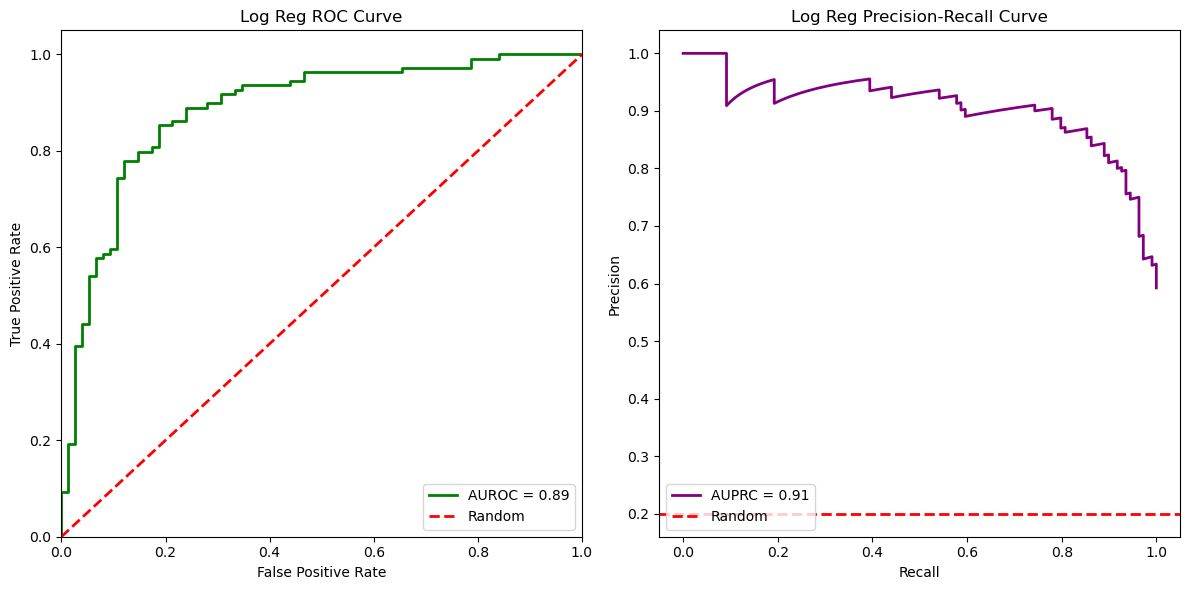

Log Reg - Accuracy: 0.81, F1 Score: 0.83


In [201]:
# roc = receiver operating characteristic; common plot for evalutaing
# auc = area under [roc] curve; 0 == shit, 0.5 == random, 1 == perfect
# precision recall + average precision interpretations depend on class imbalance bw variables 

# Train a logistic regression model
log_reg = LogisticRegression(C = 0.01, random_state=42)
log_reg.fit(X_train, y_train)

# Predict probabilities + values
y_scores = log_reg.predict_proba(X_test)[:, 1]
y_pred = log_reg.predict(X_test)

# Compute ROC curve and ROC area
fpr, tpr, thresholds = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

# Compute Precision-Recall curve and PR area
precision, recall, thresholds = precision_recall_curve(y_test, y_scores)
average_precision = average_precision_score(y_test, y_scores)

# Plot ROC curve and Precision-Recall curve as subplots on the same figure
plot_curves(tpr,fpr,roc_auc,precision,recall,average_precision,'Log Reg')

accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print(f"Log Reg - Accuracy: {accuracy:.2f}, F1 Score: {f1:.2f}")



3. For k-NN:
■ Tune the hyperparameter n_neighbors (e.g., {1, 5, 10}) and compare its
impact on evaluation metrics.
■ Plot AUROC and AUPRC curves for the model’s best configuration.

In [202]:
from sklearn.model_selection import GridSearchCV

param_grid_knn = {'n_neighbors': [5, 10, 15, 18, 22, 27],'metric': ['euclidean', 'manhattan', 'minkowski']}

# INSTANTIATE grid search
grid_search_knn = GridSearchCV(KNeighborsClassifier(), param_grid_knn, cv=3, scoring='accuracy')
grid_search_knn.fit(X_train, y_train)

print(f"Best parameters for k-NN: {grid_search_knn.best_params_}")


Best parameters for k-NN: {'metric': 'manhattan', 'n_neighbors': 22}


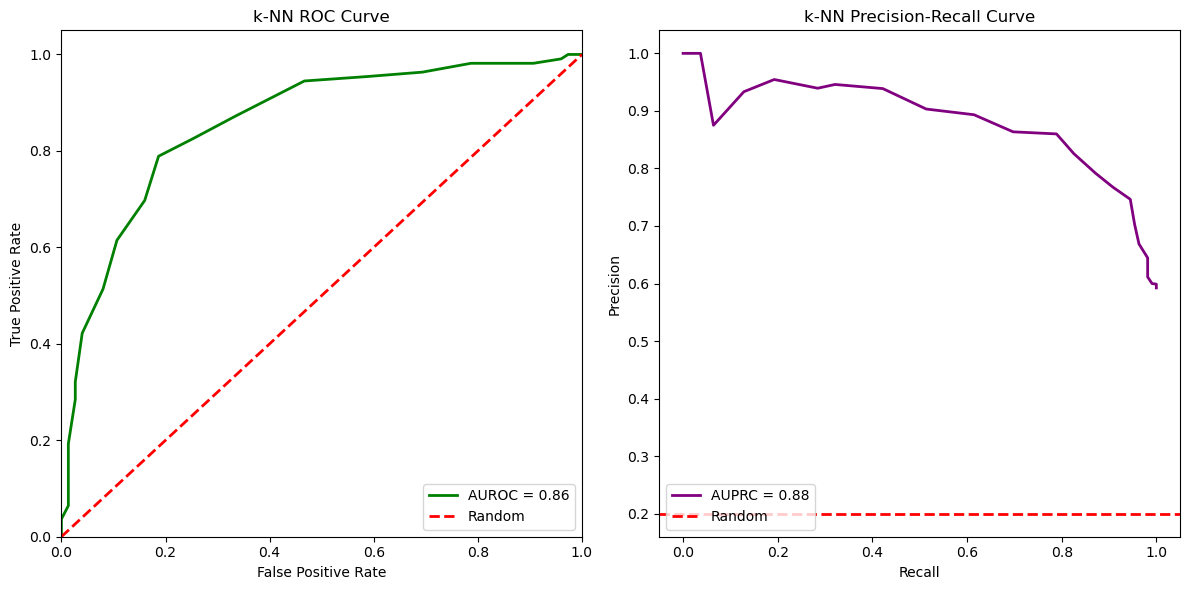

kNN - Accuracy: 0.80, F1 Score: 0.82


In [203]:
from sklearn.preprocessing import StandardScaler

X_train_scaled = StandardScaler().fit_transform(X_train)
X_test_scaled = StandardScaler().fit_transform(X_test)

# Train a k-NN classifier
# INSTANTIATE, FIT, PREDICT
knn = KNeighborsClassifier(n_neighbors=22,metric='manhattan')
knn.fit(X_train, y_train)
# Prediction as:
# probability (for curves)
y_scores_knn = knn.predict_proba(X_test)[:, 1]
# value (for evaluation metrics)
y_pred =  knn.predict(X_test)

# Compute ROC curve and ROC area
fpr_knn, tpr_knn, thresholds_knn = roc_curve(y_test, y_scores_knn)
roc_auc_knn = auc(fpr_knn, tpr_knn)

# Compute Precision-Recall curve
precision, recall, thresholds_knn = precision_recall_curve(y_test, y_scores_knn)
average_precision = average_precision_score(y_test, y_scores_knn)

plot_curves(tpr_knn,fpr_knn,roc_auc_knn,precision,recall,average_precision,'k-NN')

accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print(f"kNN - Accuracy: {accuracy:.2f}, F1 Score: {f1:.2f}")
